# Plotting Hubble Residuals
## creates Hubble diagram and plots residuals

### imports

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from sndata.csp import DR3
from sndata.sdss import Sako18Spec
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
import astropy.units as u

In [39]:
sdss_combined = pd.read_csv('~/Desktop/Research/SN-Spectral-Evolution/results/sdss_combined.csv')
sdss_combined['zCMB']

0      0.285433
1      0.261621
2      0.261621
3      0.285433
4      0.160352
         ...   
796    0.286619
797    0.054896
798    0.116277
799    0.116277
800    0.116277
Name: zCMB, Length: 801, dtype: float64

In [35]:
names = list(sdss_combined.columns)
print(names)

['feat_name', 'obj_id', 'time', 'feat_start', 'feat_end', 'vel', 'vel_err', 'vel_samperr', 'pew', 'pew_err', 'pew_samperr', 'area', 'area_err', 'area_samperr', 'spec_flag', 'feat_flag', 'notes', 'phase', 'spec_type', 'RA', 'DEC', 'Nsearchepoch', 'IAUName', 'Classification', 'Peakrmag', 'MJDatPeakrmag', 'NepochSNR5', 'nSNspec', 'nGALspec', 'zspecHelio', 'zspecerrHelio', 'zCMB', 'zerrCMB', 'x0SALT2zspec', 'x0errSALT2zspec', 'x1SALT2zspec', 'x1errSALT2zspec', 'cSALT2zspec', 'cerrSALT2zspec', 'PeakMJDSALT2zspec', 'PeakMJDderrSALT2zspec', 'muSALT2zspec', 'muerrSALT2zspec', 'fitprobSALT2zspec', 'chi2SALT2zspec', 'ndofSALT2zspec', 'deltaMLCS2k2zspec', 'deltaerrMLCS2k2zspec', 'avMLCS2k2zspec', 'averrMLCS2k2zspec', 'PeakMJDMLCS2k2zspec', 'PeakMJDerrMLCS2k2zspec', 'muMLCS2k2zspec', 'muerrMLCS2k2zspec', 'fitprobMLCS2k2zspec', 'chi2MLCS2k2zspec', 'ndofMLCS2k2zspec', 'PIaPSNIDzspec', 'logprobIaPSNIDzspec', 'lcqualityIaPSNIDzspec', 'PIbcPSNIDzspec', 'logprobIbcPSNIDzspec', 'lcqualityIbcPSNIDzspec', 

In [36]:
print([n for n in names if 'mu' in n])

['muSALT2zspec', 'muerrSALT2zspec', 'muMLCS2k2zspec', 'muerrMLCS2k2zspec']


In [38]:
print(len(sdss_combined['zCMB']))
print(len(sdss_combined['muSALT2zspec']))

801
801


In [6]:
dr3 = DR3()
dr3.download_module_data()

sako_18_spec = Sako18Spec()
sako_18_spec.download_module_data()

In [7]:
sdss_1_table = sako_18_spec.load_table('master').to_pandas(index='CID')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'ndofSALT2zspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'ndofMLCS2k2zspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'lcqualityIaPSNIDzspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'lcqualityIbcPSNIDzspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'lcqualityIIPSNIDzs

### Finding best fit

In [40]:
# make column names into variables
# use same
@np.vectorize
def dist_mod_chisq(ho):
    cosmo = FlatLambdaCDM(H0=ho * u.km / u.s / u.Mpc, Om0=0.315)
    model_dist_mod = cosmo.distmod(sdss_combined['zCMB'])
    dist_mod = sdss_combined['muSALT2zspec']
    dist_mod = dist_mod.to_numpy()
    dist_mod = dist_mod*u.mag
    # do we need to worry about error in the Om0 calculation
    chisq, p = scipy.stats.chisquare(dist_mod, model_dist_mod)
    chisq = chisq / u.mag
    return(chisq)

In [19]:
ho_fit = scipy.optimize.minimize(dist_mod_chisq, 70)
ho_fit

      fun: 0.716862944405646
 hess_inv: array([[24.57484395]])
      jac: array([8.12858343e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([68.32005572])

### creating our universe model

In [8]:
# creating cosmo model
our_cosmo = FlatLambdaCDM(H0 = 68.32005572 * u.km / u.s / u.Mpc, Om0=0.315 )

In [9]:
our_cosmo

FlatLambdaCDM(H0=68.3 km / (Mpc s), Om0=0.315, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)

In [10]:
zvals = np.linspace(0, 6, 801)
dist = our_cosmo.angular_diameter_distance(zvals)
ages = np.array([13, 10, 8, 6, 5, 4, 3, 2, 1.5, 1.2, 1])*u.Gyr
#ageticks = [z_at_value(our_cosmo.age, age) for age in ages]

### calculating distance moduli to plot

In [41]:
z = sdss_combined['zCMB']
model_dist_mod = our_cosmo.distmod(z)
model_no_units = model_dist_mod/u.mag
model_no_units = [float(i) for i in model_no_units]
dist_mod = sdss_combined['muSALT2zspec']
dist_mod = dist_mod.to_numpy()
dist_mod_units = dist_mod*u.mag
model_dist = our_cosmo.angular_diameter_distance(z)
log_y_data = np.log(model_no_units)
np.polyfit(z, log_y_data, 1)

array([0.42329637, 3.5991767 ])

In [14]:
dist_mod_err = sdss_combined['muerrSALT2zspec']
dist_mod_err = dist_mod_err.to_numpy()
dist_mod_err = dist_mod_err

### plotting

(0.0, 5.9)

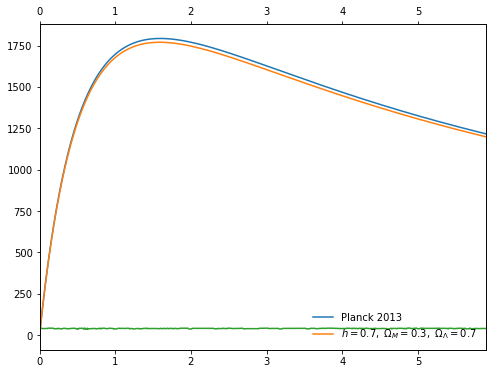

In [15]:
from astropy.cosmology import Planck13
dist2 = Planck13.angular_diameter_distance(zvals)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(zvals, dist2, label='Planck 2013')
ax.plot(zvals, dist, label=
        '$h=0.7,\ \Omega_M=0.3,\ \Omega_\Lambda=0.7$')
ax.plot(zvals, dist_mod)
ax.legend(frameon=0, loc='lower right')
ax2 = ax.twiny()
zmin, zmax = 0.0, 5.9
ax.set_xlim(zmin, zmax)
ax2.set_xlim(zmin, zmax)

Text(0, 0.5, 'distance modulus (mag)')

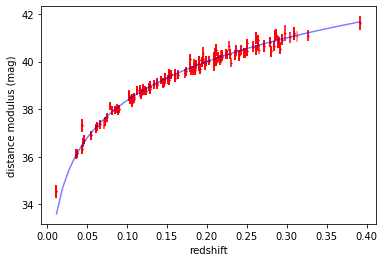

In [28]:
z_plot = np.linspace(np.min(z), np.max(z))
plot_dist_mod = our_cosmo.distmod(z_plot)
plt.plot(z_plot, plot_dist_mod,  color='blue', alpha=0.5,label=
        '$h=0.7,\ \Omega_M=0.3,\ \Omega_\Lambda=0.7$')
plt.scatter(z, dist_mod_units, color = 'red', s=0.8, alpha=0.5)
#plt.scatter(z, model_dist_mod-dist_mod_units, color = 'green', s=0.8, alpha=0.5)
#plt.plot(z_log, model_no_units)
plt.errorbar(z, dist_mod, yerr = dist_mod_err, fmt = 'none', color = 'red', s=0.8, alpha = 0.5)
plt.xlabel('redshift')
plt.ylabel('distance modulus (mag)')

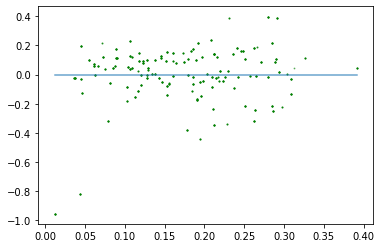

In [17]:
zeros = np.zeros(len(z))
plt.scatter(z, model_dist_mod-dist_mod_units, color = 'green', s=0.8, alpha=0.5)
plt.plot(z, zeros, alpha = 0.5)

In [ ]:
z_log = np.exp((model_no_units-3.5991767)/0.42329637)